# Prerequisites

- Make sure to use a pythen environment > V.3.11 

- In terminal, run 
```bash
pip install -r /mikael/requirements.txt
```


In [36]:
# Data handling
import pickle
import pandas as pd

# Helper functions
from functions import get_days_sinse_beginning_of_year, get_seconds_of_day

# Types handling
import numpy as np
from fractions import Fraction

# Data science
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine learning tool
import xgboost as xgb
# Optimization / feature engineering tools
import optuna

# Plotting
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# Smart options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

# Looking at the target

In [2]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

<Axes: title={'center': 'target  C'}, xlabel='time'>

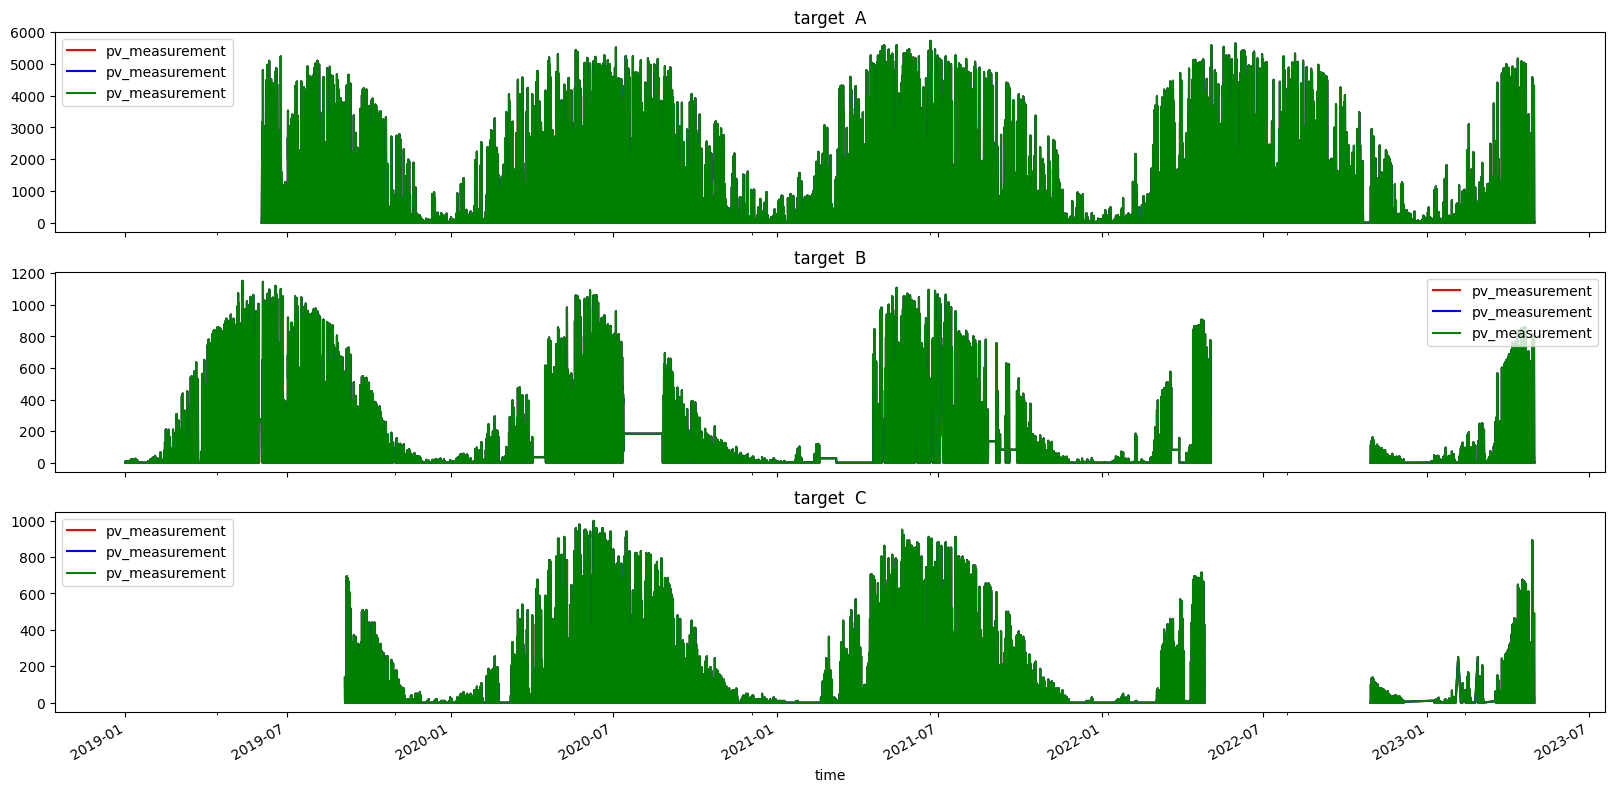

In [3]:
# Plotting a single feature
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'pv_measurement'
train_a[['time', feature_name]].set_index('time').plot(ax=axs[0], title='target A', color='red')
train_a[['time', feature_name]].set_index('time').plot(ax=axs[0], title='target A', color='blue')
train_a[['time', feature_name]].set_index('time').plot(ax=axs[0], title='target  A', color='green')

train_b[['time', feature_name]].set_index('time').plot(ax=axs[1], title='target  B', color='red')
train_b[['time', feature_name]].set_index('time').plot(ax=axs[1], title='target  B', color='blue')
train_b[['time', feature_name]].set_index('time').plot(ax=axs[1], title='target  B', color='green')

train_c[['time', feature_name]].set_index('time').plot(ax=axs[2], title='target  C', color='red')
train_c[['time', feature_name]].set_index('time').plot(ax=axs[2], title='target  C', color='blue')
train_c[['time', feature_name]].set_index('time').plot(ax=axs[2], title='target  C', color='green')

# Looking at A, B, C features

In [4]:
# Estimate
X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

# Test estimates
X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

# Observations
X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

# Targets
Y_train_observed_a = pd.read_parquet('../A/train_targets.parquet')
Y_train_observed_b = pd.read_parquet('../B/train_targets.parquet')
Y_train_observed_c = pd.read_parquet('../C/train_targets.parquet')


In [46]:
X_test_estimated_a.head()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2023-04-30 07:00:04,2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,0.0,0.0,0.0,0.0,80.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,1000.700012,1007.000000,0.0,0.0,80.300003,1013.299988,NaN,0.0,0.0,0.0,0.0,10.520000,-11.185,0.0,273.799988,80.699997,30210.699219,4.0,2.2,3.4,-0.0
1,2023-04-30 07:00:04,2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,0.0,0.0,0.0,0.0,77.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.700012,0.0,0.0,1000.599976,1006.900024,0.0,0.0,80.300003,1013.200012,NaN,0.0,0.0,0.0,0.0,14.203000,-10.825,0.0,273.799988,77.000000,30003.599609,4.0,2.1,3.4,-0.0
2,2023-04-30 07:00:04,2023-05-01 00:30:00,4.3,1.287,912.700012,0.0,0.0,1068.300049,0.0,271.600006,0.0,0.0,0.0,0.0,73.099998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.599976,0.0,0.0,1000.500000,1006.700012,0.0,0.0,80.300003,1013.000000,NaN,0.0,0.0,0.0,0.0,17.868999,-10.360,0.0,273.799988,73.099998,29797.099609,3.9,2.1,3.3,-0.0
3,2023-04-30 07:00:04,2023-05-01 00:45:00,4.3,1.287,912.700012,0.0,0.0,1081.900024,0.0,271.600006,0.0,0.0,0.0,0.0,69.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.500000,0.0,0.0,1000.400024,1006.599976,0.0,0.0,80.199997,1012.900024,NaN,0.0,0.0,0.0,0.0,21.514000,-9.794,0.0,273.799988,69.000000,29618.599609,3.9,2.0,3.3,-0.0
4,2023-04-30 07:00:04,2023-05-01 01:00:00,4.3,1.287,NaN,0.0,0.0,1095.400024,0.0,271.600006,0.0,0.0,0.0,0.0,64.500000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.299988,0.0,0.0,1000.200012,1006.500000,0.0,0.0,80.199997,1012.799988,NaN,0.0,0.0,0.0,0.0,25.135000,-9.128,0.0,273.799988,64.500000,29507.500000,3.9,2.0,3.3,-0.0


<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

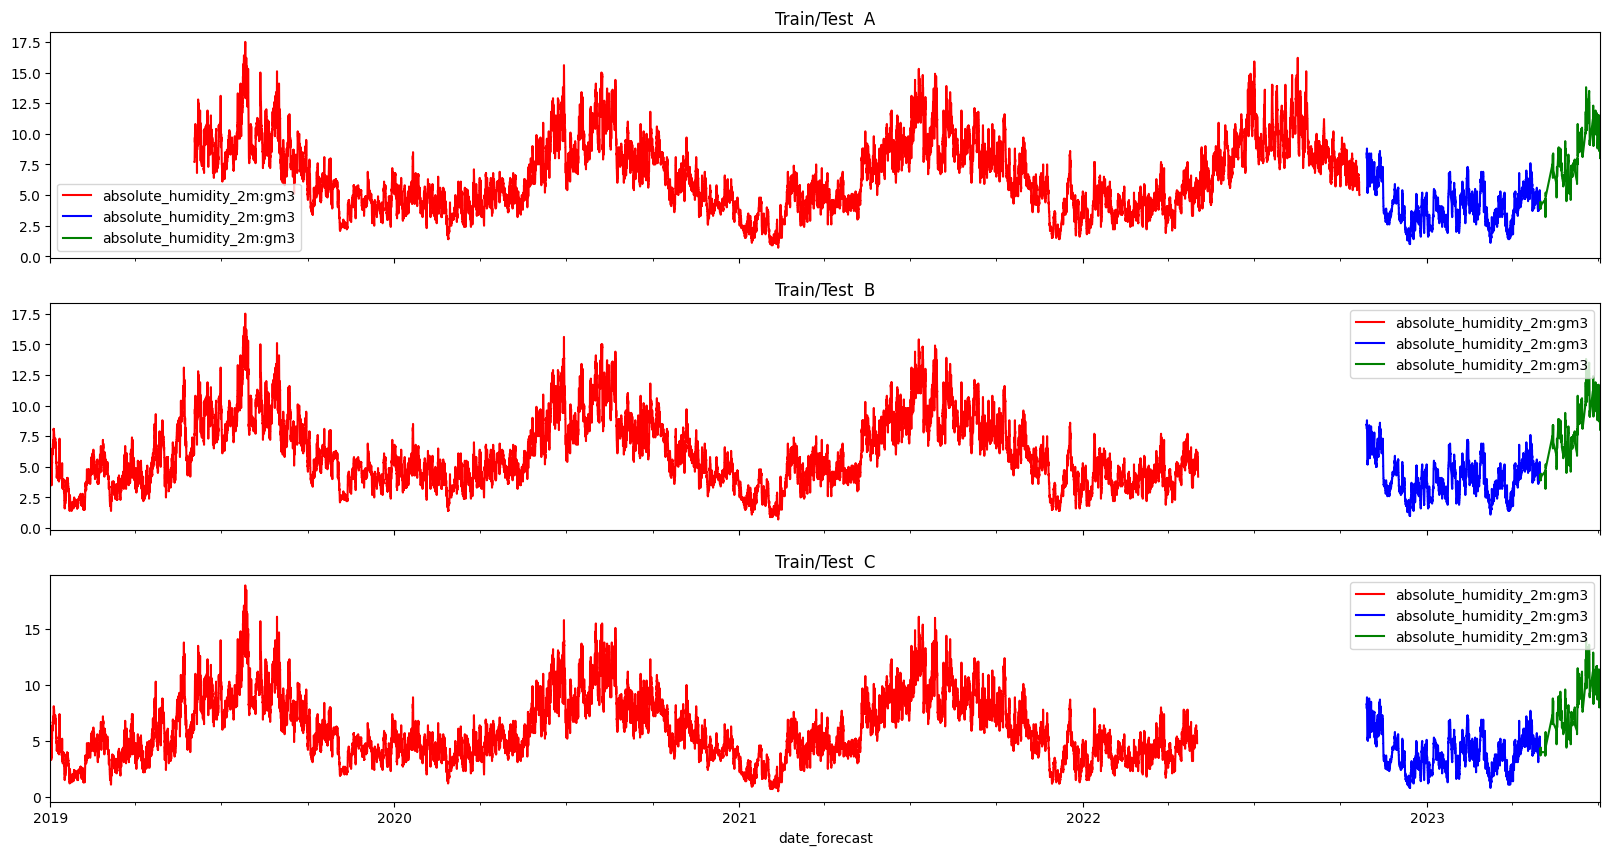

In [5]:
# Plotting a single feature
feature_name = 'absolute_humidity_2m:gm3'

fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
X_train_observed_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
X_train_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
X_test_estimated_a[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

X_train_observed_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
X_train_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
X_test_estimated_b[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

X_train_observed_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
X_train_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
X_test_estimated_c[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

# Creating the dataset

NB: Looking mainly at "A"

1. Group the data by whole hours on row mean
2. Merge train and target (simplify feature engineering)

In [25]:
X_train_group_a = X_train_estimated_a.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean().reset_index()
X_train_group_a.rename(columns={"date_forecast":"time"}, inplace=True)

inner_merge = pd.merge(X_train_group_a, Y_train_observed_a, on="time", how="inner")
id_columns = [c for c in inner_merge.columns if ":idx" in c]
id_columns

['dew_or_rime:idx',
 'is_day:idx',
 'is_in_shadow:idx',
 'precip_type_5min:idx',
 'snow_drift:idx']

# Target encoding and features

The ":idx" columns are categorical values sampled from [0, 0.25, 0.5, 0.75, 1]

What target encoding does:
- maps the categorical value to the target value at this time

In [7]:
target = ['pv_measurement']
target_encode_df = inner_merge[id_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in id_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = inner_merge.drop(id_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_target = pd.concat([score_target_drop, target_df], axis = 1)


# Features
score_target["year"] = inner_merge["time"].apply(lambda datestring: np.datetime64(datestring).astype(pd.Timestamp).year)
score_target["month"] = inner_merge["time"].apply(lambda datestring: np.datetime64(datestring).astype(pd.Timestamp).month)
score_target["seconds_in_day"] = inner_merge["time"].apply(lambda datestring: get_seconds_of_day(datestring))
score_target["days_sinse_jan_1"] = inner_merge["time"].apply(lambda datestring: get_days_sinse_beginning_of_year(datestring))

In [24]:
score_target[id_columns]

,dew_or_rime:idx,is_day:idx,is_in_shadow:idx,precip_type_5min:idx,snow_drift:idx
0,1.437064,0.093755,1.379884,356.630216,339.780637
1,1.437064,0.093755,1.379884,356.630216,339.780637
2,1.437064,0.093755,1.379884,60.104638,339.780637
3,1.437064,0.093755,1.379884,60.104638,339.780637
4,1.437064,0.093755,1.379884,60.104638,339.780637
...,...,...,...,...,...
4413,358.686694,14.765766,87.017500,356.630216,339.780637
4414,358.686694,0.093755,1.379884,356.630216,339.780637
4415,358.686694,0.093755,1.379884,356.630216,339.780637
4416,358.686694,0.093755,1.379884,356.630216,339.780637


# Cleaning

In [8]:
inner_to_split = score_target.copy().drop(columns=["date_calc", "time"])
non_id_columns = [c for c in inner_to_split.columns if ":idx" not in c]

inner_to_split[id_columns].fillna(0, inplace=True)
inner_to_split[non_id_columns].fillna(inner_to_split.mean(), inplace=True)

inner_to_split = inner_to_split.astype("float")

X = inner_to_split[[c for c in inner_to_split.columns if c != "pv_measurement"]]
Y = inner_to_split["pv_measurement"]

# Correlations

<Axes: >

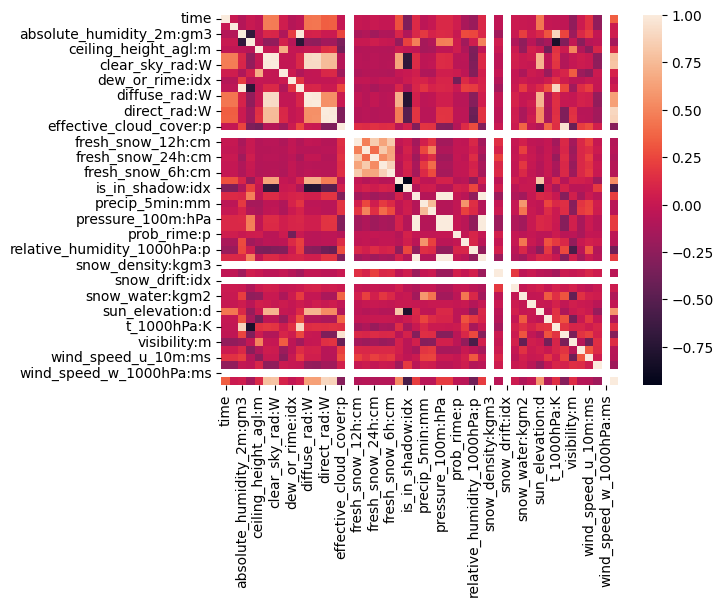

In [9]:
sns.heatmap(inner_merge.corr())

# Model training, tuning and testing

- model
XGBoost regression model

- tuning
optuna

## Preperations

1. Split the data
2. define the tuning objective
- "minimize" the mean square error

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10, test_size=0.20)

def objective(trial):
    param = {
        "objective":"reg:linear",
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [27]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=100)

[I 2023-09-27 15:12:24,002] A new study created in memory with name: regression
[I 2023-09-27 15:12:24,357] Trial 0 finished with value: 129612.00267354808 and parameters: {'max_depth': 1, 'learning_rate': 0.2731897448349255, 'n_estimators': 749, 'min_child_weight': 9, 'gamma': 0.5945047281757676, 'subsample': 0.9678967428195632, 'colsample_bytree': 0.5419238732633486, 'reg_alpha': 0.14576824743959585, 'reg_lambda': 0.800411409387688, 'random_state': 257}. Best is trial 0 with value: 129612.00267354808.
[I 2023-09-27 15:12:25,216] Trial 1 finished with value: 149897.7826661795 and parameters: {'max_depth': 6, 'learning_rate': 0.8999213765375342, 'n_estimators': 663, 'min_child_weight': 10, 'gamma': 0.3042888564981293, 'subsample': 0.7037651495756623, 'colsample_bytree': 0.7276877941944453, 'reg_alpha': 0.9452864973155483, 'reg_lambda': 0.18435144753484223, 'random_state': 564}. Best is trial 0 with value: 129612.00267354808.
[I 2023-09-27 15:12:25,412] Trial 2 finished with value: 9524

In [47]:
model = xgb.XGBRegressor(**study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=False))
print('graded! MAE: ', mean_absolute_error(y_test, y_pred))

R2:  0.8984883296196947
RMSE:  255.60830096450886
graded! MAE:  89.84364868886651


## Features

<Axes: >

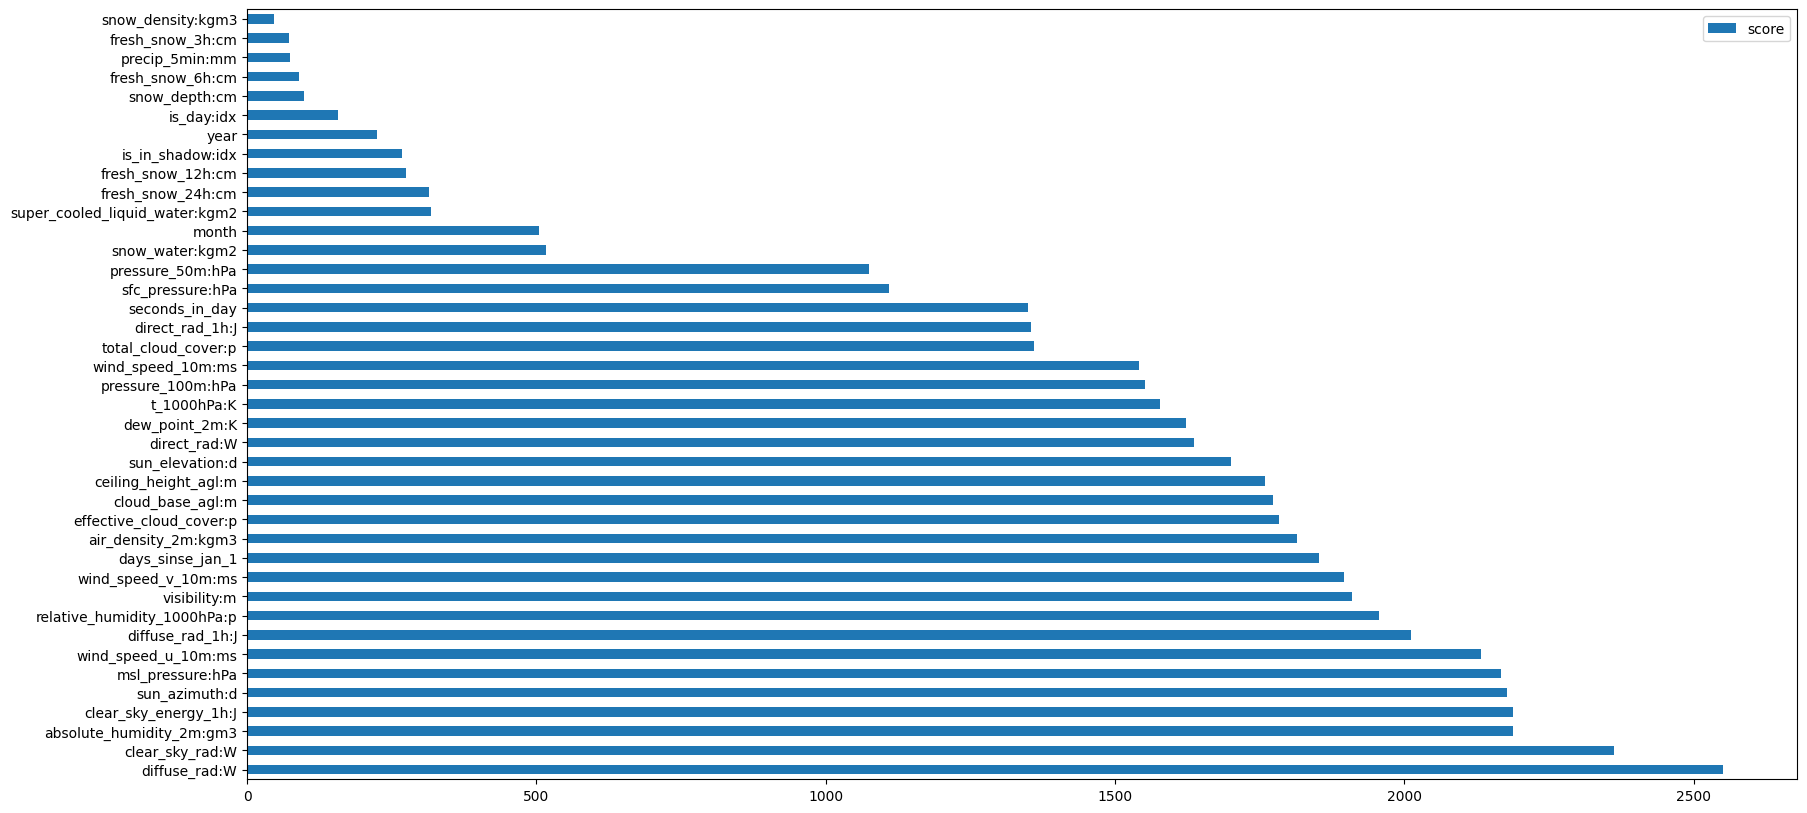

In [33]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

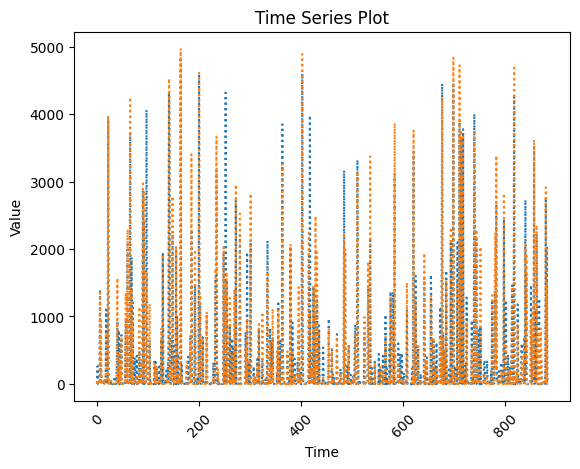

In [48]:
# Create the plot
df_y = pd.DataFrame({
    "Y pred": y_pred,
    "Y test": y_test
})

plt.plot(np.arange(len(df_y)), df_y, linestyle = 'dotted')

# Add title and axis labels
plt.title('Time Series Plot')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [31]:
# filename = "xgbregressor.pkl"
# pickle.dump(model, open(filename, "wb"))